In [25]:
import os
import pathlib
import nltk
import numpy as np
from unicodedata import normalize
import collections
%reload_ext autoreload
%autoreload 2

from simplifier import *

nltk.download('words')


[nltk_data] Downloading package words to /home/filipp/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [7]:
path_data = 'data-simplification/wikilarge/wiki.full.aner.'

In [8]:
train_src = open(path_data+'train.src', "r").readlines()
train_dst = open(path_data+'train.dst', "r").readlines()
train_ori_src = open(path_data+'ori.train.src', "r").readlines()
train_ori_dst = open(path_data+'ori.train.dst', "r").readlines()

valid_src = open(path_data+'valid.src', "r").readlines()
valid_dst = open(path_data+'valid.dst', "r").readlines()
valid_ori_src = open(path_data+'ori.valid.src', "r").readlines()
valid_ori_dst = open(path_data+'ori.valid.dst', "r").readlines()

### Comparison of datasets; will work with original first. Named entity identification is applied to get the modified dataset. Might facilitate trainining working with this.

In [9]:
train_src[114]

'ORGANIZATION@1 crews conducted backburning operations to ensure containment of the fire on NUMBER@1 February , warning residents of areas between LOCATION@1 and Warragul about smoke from those fires .\n'

In [10]:
train_ori_src[114]

'DSE crews conducted backburning operations to ensure containment of the fire on 9 February , warning residents of areas between Pakenham and Warragul about smoke from those fires .\n'

In [11]:
train_ori_dst[114]

'People between Pakenham and Warragul were warned about smoke from those fires .\n'

In [12]:
train_dst[114]

'People between LOCATION@1 and Warragul were warned about smoke from those fires .\n'

In [13]:
valid_ori_dst[11]

'Thousands of young people from all over the world went to San Francisco to help create a hippie counterculture . The Summer of Love made the rest of America much more aware of the hippie movement .\n'

In [33]:
embedding_index = {}
file = os.path.join(str(pathlib.Path.home())+"/GloVe","glove.6B.100d.txt")
f= open(file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs



### A glimpse at the representations.

In [37]:
i = 0
for key, value in embedding_index.items():
    if i>5:
        break
    print(key, value)
    print(value.shape)
    i += 1

the [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.270

In [20]:
clean_txt = clean(train_ori_src)

In [18]:
train_ori_src[0:2]

["There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .\n",
 "In a remarkable comparative analysis , Mandaean scholar Säve-Söderberg demonstrated that Mani 's Psalms of Thomas were closely related to Mandaean texts .\n"]

In [19]:
clean_txt[0:400]

'there is manuscript evidence that austen continued to work on these pieces as late as the period a and that her niece and nephew anna and james edward austen made further additions as late asin a remarkable comparative analysis mandaean scholar demonstrated that mani psalms of thomas were closely related to mandaean textsbefore persephone was released to hermes who had been sent to retrieve her ha'

In [20]:
token_list_src = nltk.word_tokenize(clean_txt)
print(token_list_src[0:20],"\n")
print("Total tokens : ", len(token_list_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'austen', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'a', 'and', 'that'] 

Total tokens :  5742368


In [21]:
# comparison with source tokens when entities replaced by placeholders
token_list_with_ent_src = nltk.word_tokenize(clean(train_src))
print(token_list_with_ent_src[0:20],"\n")
print("Total tokens : ", len(token_list_with_ent_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'a', 'and', 'that', 'her'] 

Total tokens :  4961048


In [22]:
#total vocabulary size in source
len(set(token_list_src))

332341

### Looking at the frequencies

In [32]:
#embedding_size = 100 # GloVe 100d
token_list_src_over_threshold = build_vocabulary(tokenize(clean(train_ori_src)), threshold=5)
vocabulary_size_source = len(token_list_src_over_threshold) + 1
print(vocabulary_size_source)
token_list_src_over_threshold[:10]

45329


[('the', 414529),
 ('of', 238408),
 ('and', 180703),
 ('in', 180597),
 ('a', 158684),
 ('is', 116580),
 ('to', 102777),
 ('was', 61810),
 ('as', 55788),
 ('by', 45144)]

### Which words/tokens from corpus are missing in GloVe; obviously lots of misspelled/not properly separated words.

In [48]:
not_in_GloVe = []
for word, _ in token_list_src_over_threshold:
    if word not in embedding_index:
        not_in_GloVe.append(word)
len(not_in_GloVe)

5916

### Using spell checker a la Norvig

In [99]:
from spellchecker import *

In [47]:
separate_words("umbrellaas", embedding_index)

['umbrella', 'as']

#### Separating a word not in the embedding might give two words in the embedding. Run a couple of times, to see that the number of words not in GloVe decreases

In [79]:
for word in not_in_GloVe:
    if len(separate_words(word, embedding_index))>1:
        not_in_GloVe.remove(word)
        
len(not_in_GloVe)

374

In [80]:
not_in_GloVe[:20]

['rttemberg',
 'encyclopdia',
 'sseldorf',
 'zaglossus',
 'urttemberg',
 'aurantifolia',
 'encyclopa',
 'giravanz',
 'schidlof',
 'graubunden',
 'radevormwald',
 'gerresheim',
 'wositzky',
 'popofyearthe',
 'lagerphonist',
 'largentiere',
 'nchengladbach',
 'pruvincia',
 'lyrikpreis',
 'oxudercinae']

In [83]:
improved_token_list = improve_token_list([x[0] for x in token_list_src_over_threshold], \
                                         embedding_index, separate_words)

In [84]:
improved_token_list = list((set(improved_token_list)))
len(improved_token_list)

42118

### Creating token-index-dictionary

In [100]:
tokenizer_src = build_word2index(improved_token_list)

In [101]:
len(tokenizer_src)

42119

### embedding matrix to use the GloVe embedding in the model later

In [37]:
vocabulary_size_source = len(tokenizer_src)+1
embedding_matrix = np.zeros((vocabulary_size_source, embedding_size))
for word, idx in tokenizer_src.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [38]:
test = train_ori_src[120]
test

'Sirius left Portsmouth on 13 May 1787 , and arrived at Port Jackson on 26 January 1788 .\n'

In [39]:
len(tokenizer(test))

16

### Let's look at sentence lengths

In [85]:
lengths=[]
lengths = [len((tokenizer(x))) for x in train_ori_src]

In [86]:
print("min", np.min(lengths))
print("mean", np.mean(lengths))
print("max", np.max(lengths))
print("std", np.std(lengths))

min 0
mean 22.678625650299256
max 104
std 11.685398987054729


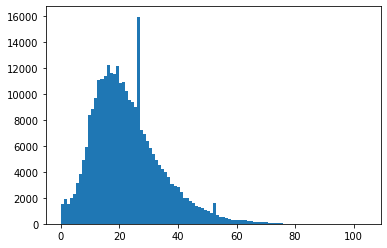

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()
plt.close()

In [88]:
np.argmax(lengths)

26105

In [89]:
np.argmin(lengths)

607

In [90]:
train_ori_src[26105]

'DreamWorks Animation has produced some of the highest grossing animated hits of all time , such as Antz -LRB-/O1998/O-RRB- , The Prince of Egypt -LRB-/O1998/O-RRB- , Shrek -LRB-/O2001/O-RRB- , its sequels Shrek 2 -LRB-/O2004/O-RRB- , Shrek the Third -LRB-/O2007/O-RRB- and Shrek Forever After -LRB-/O2010/O-RRB- ; Shark Tale -LRB-/O2004/O-RRB- , Madagascar -LRB-/O2005/O-RRB- , Over the Hedge -LRB-/O2006/O-RRB- , Flushed Away -LRB-/O2006/O-RRB- , Bee Movie -LRB-/O2007/O-RRB- , Kung Fu Panda -LRB-/O2008/O-RRB- and How to Train Your Dragon -LRB-/O2010/O-RRB- .\n'

In [91]:
train_ori_src[607]

"! ''\n"

In [103]:
sentence_length = 50

In [104]:
train_x = np.array([encoder(tokenizer(line), \
                            tokenizer_src, sentence_length) for line in \
                    train_ori_src]).reshape(-1, sentence_length)

In [105]:
train_x.shape

(296402, 50)

In [106]:
get_word(3760, tokenizer_src)

'sakamoto'

In [107]:
print(train_ori_src[12:13])
print([tokenizer(line) for line in train_ori_src[12:13]])
print(train_x[12:13])

['Plays and comic puppet theater loosely based on this legend were popular throughout Germany in the 16th century , often reducing Faust and Mephistopheles to figures of vulgar fun .\n']
[['plays', 'and', 'comic', 'puppet', 'theater', 'loosely', 'based', 'on', 'this', 'legend', 'were', 'popular', 'throughout', 'germany', 'in', 'the', '16th', 'century', 'often', 'reducing', 'faust', 'and', 'mephistopheles', 'to', 'figures', 'of', 'vulgar', 'fun']]
[[31839 40992 35457 29550 13283 36344 15571 12408 17487 11783 25661 36028
    604 21796 33379 16459 42119 35163 25557 11060 16386 40992 23937  2512
  39849 31235 38069 36327     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


In [108]:
lengths_dst = [len((tokenizer(x))) for x in train_ori_dst]

In [110]:
print("min", np.min(lengths_dst))
print("mean", np.mean(lengths_dst))
print("max", np.max(lengths_dst))
print("std", np.std(lengths_dst))

min 0
mean 16.679013636885042
max 80
std 10.492046320896975


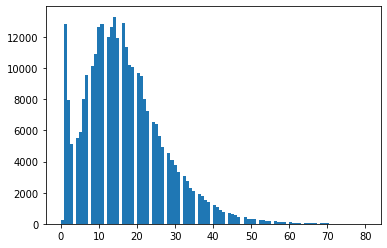

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths_dst, bins=100)
plt.show()
plt.close()

In [112]:
sentence_length_dst = 50

### Look at output vocabulary

In [113]:
token_list_dst_over_threshold = build_vocabulary(tokenize(clean(train_ori_dst)), threshold=5)
vocabulary_size_dst = len(token_list_dst_over_threshold) + 1
print(vocabulary_size_dst)
token_list_dst_over_threshold[:10]

34929


[('the', 300506),
 ('of', 169568),
 ('in', 134603),
 ('a', 119036),
 ('and', 114305),
 ('is', 109630),
 ('to', 69806),
 ('was', 54588),
 ('for', 31547),
 ('by', 29698)]

In [115]:
improved_token_list_dst = improve_token_list([x[0] for x in token_list_dst_over_threshold], \
                                         embedding_index, separate_words)
improved_token_list_dst = list((set(improved_token_list_dst)))
vocabulary_size_dst = len(improved_token_list_dst) + 1
print(vocabulary_size_dst)

32119


In [116]:
tokenizer_dst = build_word2index(improved_token_list_dst)
len(tokenizer_dst)

32119

In [117]:
train_y = np.array([encoder(tokenizer(line), \
                            tokenizer_dst, sentence_length_dst) for line in \
                    train_ori_dst]).reshape(-1, sentence_length_dst)

In [118]:
train_y.shape

(296402, 50)

In [119]:
import gc
gc.collect()

13865

In [120]:
0 in tokenizer_src.values()

False

In [ ]:
from tensorflow.keras import models, layers, callbacks, optimizers
import datetime
#from simplifier import generator
#import tensorboard

model = models.Sequential()
model.add(layers.Embedding(          #word embedding
    vocabulary_size_source,
    #embedding_size,
    200,
    input_length=sentence_length,
    embeddings_initializer='lecun_uniform',
    mask_zero=True

))
model.add(layers.LSTM(200))#, return_sequences=True))
#model.add(layers.LSTM(256)) #
model.add(layers.RepeatVector(sentence_length_dst))
#model.add(layers.LSTM(256, return_sequences=True)) #
model.add(layers.LSTM(200, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(vocabulary_size_dst+1, activation='softmax')))
#model.add(layers.Dense(vocabulary_size_source+1, activation='softmax'))

#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = True #False   #freeze

model.summary()


rms = optimizers.RMSprop(lr=0.007)
model.compile(
    optimizer=rms,
    #optimizer="adam",
    #loss="categorical_crossentropy",
    loss="sparse_categorical_crossentropy",
    #metrics=["accuracy"]

)
batch_size = 50
n_samples = 300 #train_x.shape[0]
history = model.fit_generator(
    generator(train_x, train_y, batch_size, samples=n_samples, shf=False, onehot=False),
    #data_gen,
    #(train_gen(train_x, 500), one_hot_encode_output(train_y_gen)),
    epochs=20,
    #batch_size=50,
    #validation_split=0.2,
    #steps_per_epoch = train_x.shape[0]/batch_size,
    steps_per_epoch = n_samples/batch_size,
    

)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 200)           9065800   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 50, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 200)           320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 32120)         6456120   
Total params: 16,163,520
Trainable params:

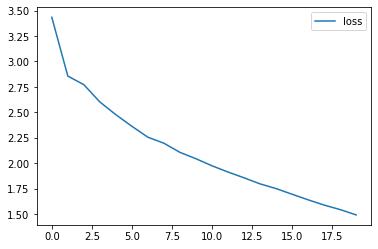

In [106]:
import matplotlib.pyplot as plt

plt.plot(model.history.history["loss"], label="loss")
#plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()
plt.close()

In [438]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 60, 100)           4212000   
_________________________________________________________________
lstm_94 (LSTM)               (None, 100)               80400     
_________________________________________________________________
repeat_vector_33 (RepeatVect (None, 60, 100)           0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
time_distributed_31 (TimeDis (None, 60, 42121)         4254221   
Total params: 8,627,021
Trainable params: 8,627,021
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.predict(train_x[10:11]).shape

(1, 10, 42121)

In [72]:
train_ori_src[10:11]

["There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .\n"]

In [73]:
train_x[10:11]

array([[21327, 24375, 35953, 21518, 31768,  7542, 23995, 34391, 15348,
        18406]], dtype=int32)

In [107]:
model.predict_classes(train_x[10:11])

array([[29334, 32119, 23476, 29334, 26272, 24342, 21740,  8083, 11228,
        21300, 21300, 19873, 32119, 32119, 32119, 29334, 29334, 29334,
        29334, 29334, 29334, 29334, 29334, 29334, 29334, 29334, 29334,
        29334,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])

In [135]:
convert(model.predict_classes(train_x[10:11]), token_dict=tokenizer_dst)

['<UNK>  massey a circle  vicious   <UNK>                                        ',
 'it is meanings cocteau emmy and                                            ',
 'he <UNK>                                                ',
 'he way have wales the out and the and    several                                     ']

In [116]:
convert(train_x[10:11], tokenizer_src)

['the album was released on march <UNK>  through elektra records and was met with high critical reception                                ',
 'it was farmed and eaten by the ancient romans <UNK> usually as a snack <UNK> hence the word edible in its name                            ',
 'she married enrique rousseau shortly thereafter                                            ',
 'on <UNK> april with her suite much diminished marie louise and the three year old king of rome were back in rambouillet where they met her father the emperor francis ii of austria and the emperor alexander i of russia          ']

In [137]:
train_ori_dst[10:11]

['SliTaz GNU/Linux is a software project started by Christophe Lincoln in 2006 .\n',
 'This is the current generation of the Volkswagen Passat .\n',
 'Their upcoming album , Blue Sky Noise , will be released on April 20 , 2010 on Atlantic Records as the band has finished their term with Equal Vision Records .\n',
 'Before releasing the album , they toured with Alice Cooper , Rammstein , Deep Purple , Dream Theater , Saxon and Stratovarius .\n']

In [118]:
model.save("first_3K_smod.h5")

In [129]:
np.sum(model.get_weights()[0])

1308.4009

In [131]:
from tensorflow.keras.models import load_model
mdl = load_model("first_3K_smod.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [132]:
np.sum(mdl.get_weights()[0])

1308.4009

In [219]:
train_x[indx]

array([[14076, 30192, 38991, 17069,  2660, 20811, 21261, 18114,  5733,
         6285,  8267, 18343,  4764,  2458, 18114, 17870,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]], dtype=int32)

In [221]:
train_y[indx]

array([[10804, 23060, 29753, 13084, 23365, 15926, 27083, 13882,  4352,
         4770, 14047, 29027,  3622, 11210,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)

In [259]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)
    integers = [np.argmax(vector) for vector in prediction]
    return convert(integers, tokenizer)

In [260]:
predict_sequence(model, tokenizer_dst, train_x[10:11])

TypeError: object of type 'numpy.int64' has no len()

In [237]:
prediction = model.predict(train_x[indx], verbose=0)[0]

In [239]:
integers = [np.argmax(vector) for vector in prediction]

In [244]:
prediction[1]

array([7.7115256e-01, 1.2760270e-07, 1.6472593e-07, ..., 1.2095499e-07,
       1.4844271e-07, 6.5646149e-02], dtype=float32)